In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from global_land_mask import globe

### PPE

In [48]:
enn = np.arange(0,174)

In [3]:
for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']:
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h0.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        if en == 0:
            lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
            lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
            time = data.variables['time'][:] #(time: 36)
            
        locals()[str(en)+'_'+i] = data.variables[i][:]

In [4]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((36,len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[0:35,a,b] = 0

for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']: #
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)

In [5]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K

In [6]:
for en in enn:
    locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [7]:
for en in enn:
    locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTS_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
    locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

In [8]:
from scipy import stats
from skmisc.loess import loess
for en in enn:
    bin_means, bin_edges, binnumber = stats.binned_statistic(locals()['M_'+str(en)], locals()['U10_'+str(en)], 'mean', bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    x = np.array(bin_centers[:])
    y = np.array(bin_means[:])
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]

    l = loess(xx,yy)
    l.fit()
    pred = l.predict(xx, stderror=True)
    conf = pred.confidence()

    locals()['lowess_'+str(en)] = pred.values
    ll = conf.lower
    ul = conf.upper
    locals()['xx_'+str(en)] = xx

### MACLWP + MERRA2 REANALYSIS

In [49]:
import glob
merralist = np.sort(glob.glob('../data_merra/lat_30_70/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [51]:
mac_wind  = []
mac_theta = []


for i in range(len(merralist)): #len(maclist)
    d_path = merralist[i]
    data   = xr.open_dataset(d_path)
    mlat = data.variables['lat'][:]
    mlon = data.variables['lon'][:]
    mlev = data.variables['lev'][:]
    mU   = data.variables['U'][:]
    mV   = data.variables['V'][:]
    mT   = data.variables['T'][:]
    
    ddpath = maclist[i]
    ddata   = xr.open_dataset(ddpath)
    sfcwind= ddata.variables['sfcwind'][:]
    slat = ddata.variables['lat'][:]
    slon = ddata.variables['lon'][:]
    
    
    
#     if i==0:
#         maskm = np.ones((len(mlat),len(mlon)))

#         for a in range(len(mlat)):
#             for b in range(len(mlon)):
#                 if globe.is_land(mlat[a], mlon[b])==True:
#                     maskm[a,b] = 0
    
#     mw     = np.sqrt(np.add(mU[0,0,:,:]**2, mV[0,0,:,:]**2))
#     mtheta = np.subtract(mT[0,0,:,:], np.multiply(mT[0,1,:,:], (100/85)**(Rd/Cp)))
    
#     mmw    = np.array(np.multiply(maskm,mw)).reshape(-1)
#     mmtheta= np.array(np.multiply(maskm,mtheta)).reshape(-1)
    
#     mac_wind.extend(mmw)
#     mac_theta.extend(mmtheta)
    

In [11]:
mac_wind  = np.array(mac_wind)
mac_theta = np.array(mac_theta)

In [12]:
mac_theta_nan = mac_theta[~np.isnan(mac_theta)]
mac_wind_nan = mac_wind[~np.isnan(mac_theta)]

In [13]:
from scipy import stats
from skmisc.loess import loess

bin_means, bin_edges, binnumber = stats.binned_statistic(mac_theta_nan, mac_wind_nan, 'mean', bins=200)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

x = np.array(mac_bin_centers)
y = np.array(mac_bin_means)
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

macl = loess(xx,yy)
macl.fit()
macpred = macl.predict(xx, stderror=True)
macconf = macpred.confidence()

macloess = macpred.values
macll = conf.lower
macul = conf.upper
macxx = xx

    

### PLOT

(3.0, 13.0)

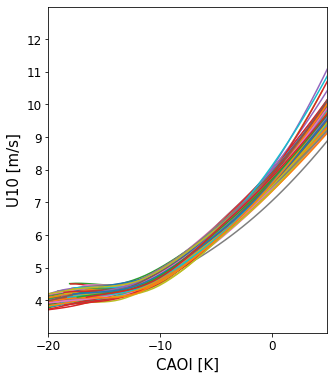

In [70]:
fig= plt.figure(figsize=(5, 6))
for en in enn:
    plt.plot(locals()['xx_'+str(en)], locals()['lowess_'+str(en)])
    
# plt.scatter(macxx, macloess, label = 'MERRA2')
# plt.title('PPE U10 vs Cold air outbreak index\n30N to 70N excluding land for \n175 ensembles(solid) and MACLWP+MERRA2(scatter)')
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.xticks([-20,-10,0],fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
# plt.savefig('/glade/u/home/geethma/link/GCMres/ppeU10vsMwithMACLWP.png')
# plt.legend(fontsize=12.0,frameon=False)
# plt.text(-47, 13, 'Solid lines - PPE', fontsize=12.0)